In [1]:
import pandas
import glob
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline

# Sequences with very few plasmids give unreliable outputs.
# A cutoff of 20 DNA counts is recommended by Ernst et. al.
DNA_COUNT_THRESH = 20

cells = ["HepG2", "K562"]
designs = ["ScaleUpDesign1", "ScaleUpDesign2"]
promoters = ["minP", "SV40P"]

In [2]:
def quantile_plot(x, y, quantiles = 5000, ax = None, s = 5):
    assert x.shape == y.shape
    data_pairs = [(X, Y) for X, Y in zip(x, y)]
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    if ax:
        ax.scatter(avg_activity, avg_score, c = 'r', s=s)
    else:
        plt.scatter(avg_activity, avg_score, c = 'r', s=s)
        plt.show()

In [3]:
def read_counts(fn):
    data = pandas.read_csv(fn, sep= '\t', header = 0)
    names  = data[["ID"]].as_matrix().reshape(-1)
    seq    = data[["Sequence"]].as_matrix().reshape(-1)
    counts = data[["Counts"]].as_matrix().reshape(-1).astype('int')
    return names, seq, counts

In [4]:
def get_counts(cell, promoters, design, names=None, seqs=None):
    # Find relevant files.
    # Note that there is one plasmid library used for each promoter.
    rna1 = glob.glob("raw/*{}_{}_{}_mRNA_Rep1*".format(cell, design, promoter))
    rna2 = glob.glob("raw/*{}_{}_{}_mRNA_Rep2*".format(cell, design, promoter))
    dna  = glob.glob("raw/*{}_{}_Plasmid*".format(design, promoter))
    assert len(rna1) == len(rna2) == len(dna) == 1

    # Read in names, sequences, and counts.
    rna1_names, rna1_seqs, rna1_counts = read_counts(rna1[0])
    rna2_names, rna2_seqs, rna2_counts = read_counts(rna2[0])
    dna_names,  dna_seqs,  dna_counts  = read_counts(dna[0])

    # ... and assure that they are concordant.
    assert np.all(rna1_seqs == rna2_seqs) and np.all(rna2_seqs == dna_seqs)
    assert np.all(rna1_names == rna2_names) and np.all(rna2_names == dna_names)
    assert rna1_counts.shape == rna2_counts.shape == dna_counts.shape

    # ... and they match the previously read names and sequences.
    if names is not None:
        assert np.all(names == dna_names)
        assert np.all(seqs  == dna_seqs)
    seqs, names = dna_seqs, dna_names
    return names, seqs, rna1_counts, rna2_counts, dna_counts

In [12]:
def act(rna, dna, thresh = 20):
    rna, dna = rna[dna > thresh], dna[dna > thresh]
    return (np.log(rna + 1) - np.log(dna + 1)
            - np.log(sum(rna + 1)) + np.log(sum(dna + 1)))

# Read in Data

In [5]:
names = {}
seqs = {}
rna1 = {}
rna2 = {}
dna  = {}
for design in designs:
    names[design] = None
    seqs[design]  = None
    rna1[design] = []
    rna2[design] = []
    dna[design] = []
    header = ['Name']
    for cell in cells:
        for promoter in promoters:
            header += ["{}-{}".format(cell, promoter)]
            (names[design], seqs[design],
             r1, r2, d) = get_counts(cell, promoters, design,
                                     names[design], seqs[design])
            rna1[design] += [r1]
            rna2[design] += [r2]
            dna[design] += [d]
    rna1[design] = np.vstack(rna1[design]).T
    rna2[design] = np.vstack(rna2[design]).T
    dna[design] = np.vstack(dna[design]).T
    assert rna1[design].shape == rna2[design].shape == dna[design].shape

# Load DESeq2

In [52]:
lfc = []
lfc_se = []
pvals = []
with open('ScaleUpDesign1-MINP-HepG2.deseq') as fp:
    print fp.readline()
    for line in fp:
        name, mean, lf2c, lf2c_se, stat, pval, padj = line.strip().split('\t')
        lfc    += [float(0 if lf2c == 'NA' else lf2c)]
        lfc_se += [float(0 if lf2c_se == 'NA' else lf2c_se)]
        pvals  += [float(1 if pval == 'NA' else pval)]
lfc = np.array(lfc)
lfc_se = np.array(lfc_se)
pvals = np.array(pvals)

"baseMean"	"log2FoldChange"	"lfcSE"	"stat"	"pvalue"	"padj"



# Compare shrunken to MLE activities

SpearmanrResult(correlation=0.93201169947156348, pvalue=0.0)


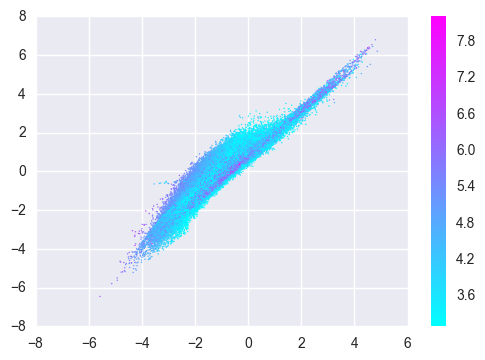

In [53]:
design = 'ScaleUpDesign1'

r1, r2 = rna1[design][:, 0], rna2[design][:, 0]
d = dna[design][:, 0]

a1, a2 = act(r1, d, -1), act(r2, d, -1)
a = (a1+a2)/2.0

sc = plt.scatter(a[d > 20], lfc[d > 20],
                 c = np.log(d+1)[d > 20],
                 cmap = 'cool',
                 s = 1, lw = 0)

print stats.spearmanr(a[d > 20],lfc[d > 20])
plt.colorbar(sc)
plt.show()

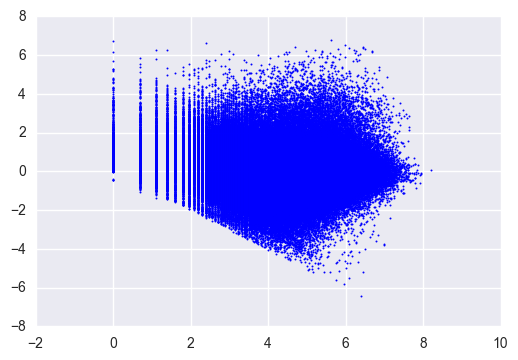

In [54]:
plt.scatter(np.log(d+1), lfc, s = 2, lw = 0)
plt.show()

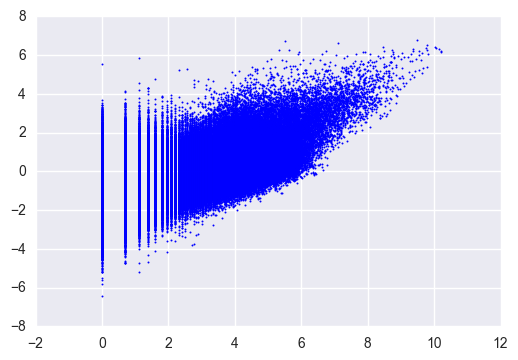

In [55]:
plt.scatter(np.log(r1+1), lfc, s = 2, lw = 0)
plt.show()

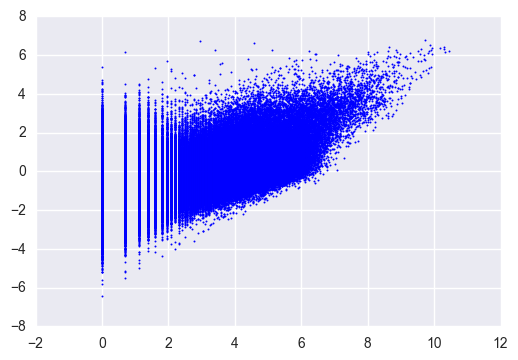

In [56]:
plt.scatter(np.log(r2+1), lfc, s = 2, lw = 0)
plt.show()

4846
SpearmanrResult(correlation=0.37691900488708496, pvalue=0.0)


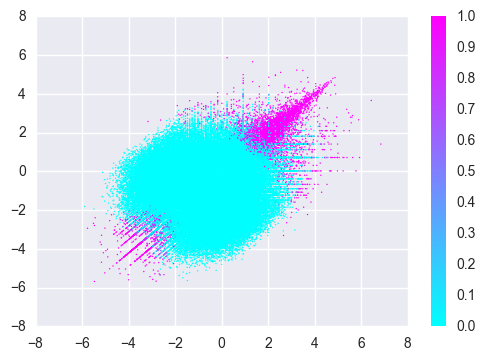

In [58]:
design = 'ScaleUpDesign1'
r1, r2 = rna1[design][:, 0], rna2[design][:, 0]
d = dna[design][:, 0]

a1, a2 = act(r1, d, -1), act(r2, d, -1)
sc = plt.scatter(a1, a2,
                 c = pvals < .1,
                 cmap = 'cool',
                 s = 1, lw = 0)
print sum(pvals < .05)
print stats.spearmanr(a1, a2)

plt.colorbar(sc)
plt.show()

4846
SpearmanrResult(correlation=0.37691900488708496, pvalue=0.0)


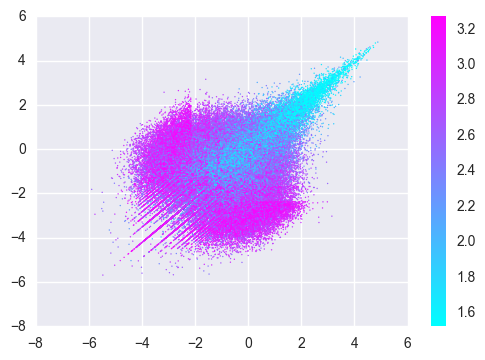

In [64]:
design = 'ScaleUpDesign1'
r1, r2 = rna1[design][:, 0], rna2[design][:, 0]
d = dna[design][:, 0]

a1, a2 = act(r1, d, -1), act(r2, d, -1)
sc = plt.scatter(a1[d > 20], a2[d > 20],
                 c = lfc_se[d > 20]**2,
                 cmap = 'cool',
                 s = 1, lw = 0)
print sum(pvals < .05)
print stats.spearmanr(a1, a2)

plt.colorbar(sc)
plt.show()

# Weighted Regression

In [82]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
design = 'ScaleUpDesign1'
BASES = ['A', 'C', 'G', 'T']
r1, r2 = rna1[design][:, 0], rna2[design][:, 0]
d = dna[design][:, 0]
def kmerize(X, k):
    bases = ['00', '01', '10', '11']
    counts = []
    for seq in X:
        binary_seq = ''.join(map(lambda x: bases[x], seq))
        count = np.zeros((4**k,), dtype = int)
        for i in range(0, len(seq) - k + 1):
            count[int(binary_seq[i*2:(i+k)*2], 2)] += 1
        counts += [count]
    return np.vstack(counts)

def seqs_to_matrix(seqs):
    return np.vstack([map(lambda x: BASES.index(x), seq)
                     for seq in seqs])

def get_X(idx, k):
    return kmerize(seqs_to_matrix(seqs[design][idx]), k)

def get_y(idx):
    a1, a2 = act(r1, d, -1), act(r2, d, -1)
    return scale((a1+a2)[idx]/2.0)

def evaluate(true, pred):
    print stats.spearmanr(true, pred)
    print stats.pearsonr(true, pred)
    plt.scatter(true, pred, s= 1, lw = 0)
    plt.show()

In [83]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
y_lfc = lfc[d > 20]
w = 1 / lfc_se[d > 20]**2

(X_train, X_test,
 y_train, y_test,
 y_shrunk_train, y_shrunk_test,
 w_train, w_test) = train_test_split(X, y, y_lfc, w,
                                     test_size = 0.2,
                                     random_state = 42)

normal_model   = SGDRegressor(penalty = 'l1',
                              n_iter = 30
                             ).fit(X_train, y_train)
shrunken_model = SGDRegressor(penalty = 'l1',
                              n_iter = 30
                             ).fit(X_train, y_shrunk_train)
weighted_model = SGDRegressor(penalty = 'l1',
                              n_iter = 30
                             ).fit(X_train, y_train,
                                   sample_weight = w_train)

SpearmanrResult(correlation=0.28124387826630909, pvalue=0.0)
(0.38307898693080872, 0.0)


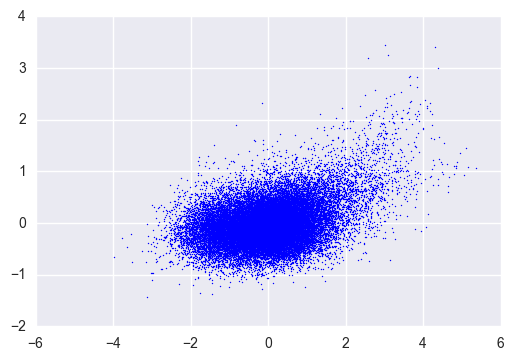

SpearmanrResult(correlation=0.26774118673220648, pvalue=0.0)
(0.3772662040928037, 0.0)


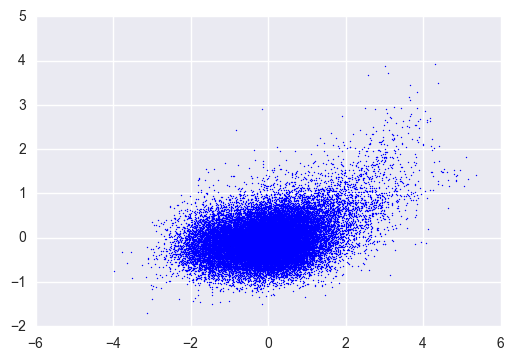

SpearmanrResult(correlation=0.28127505914983669, pvalue=0.0)
(0.38707563976913084, 0.0)


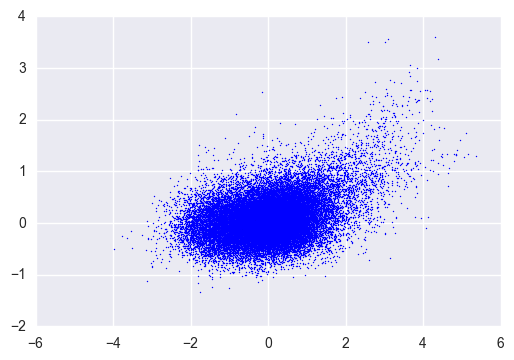

In [84]:
evaluate(y_test, normal_model.predict(X_test))
evaluate(y_test, shrunken_model.predict(X_test))
evaluate(y_test, weighted_model.predict(X_test))

SpearmanrResult(correlation=0.2490810758198789, pvalue=0.0)
(0.35121941398836859, 0.0)


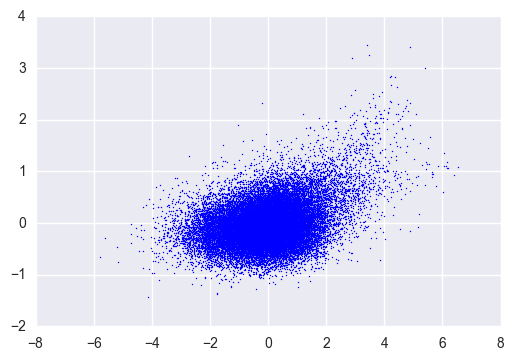

SpearmanrResult(correlation=0.24270294362413133, pvalue=0.0)
(0.35050432110168023, 0.0)


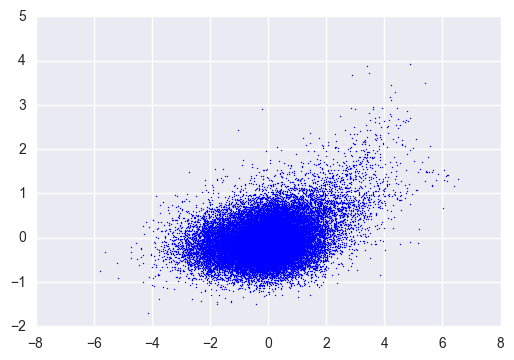

SpearmanrResult(correlation=0.24818693806311701, pvalue=0.0)
(0.35454386252884418, 0.0)


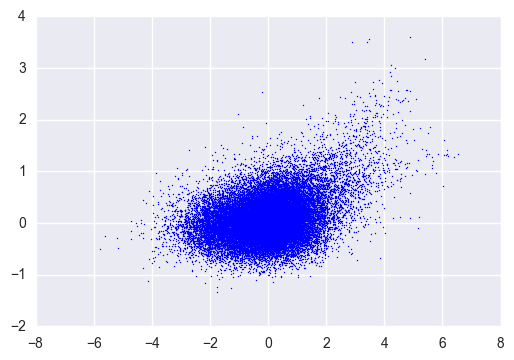

In [85]:
evaluate(y_shrunk_test, normal_model.predict(X_test))
evaluate(y_shrunk_test, shrunken_model.predict(X_test))
evaluate(y_shrunk_test, weighted_model.predict(X_test))

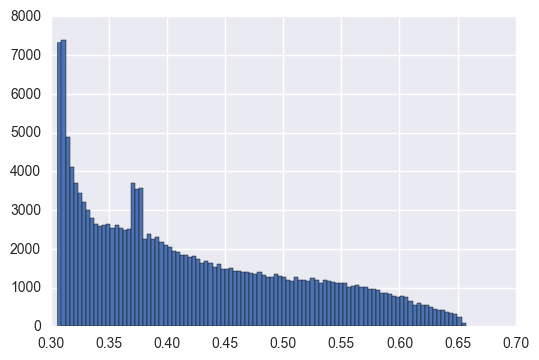

In [92]:
plt.hist(w, bins = 100)
plt.show()

# Predict statistically significant changes

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

BASES = ['A', 'C', 'G', 'T']

def kmerize(X, k):
    bases = ['00', '01', '10', '11']
    counts = []
    for seq in X:
        binary_seq = ''.join(map(lambda x: bases[x], seq))
        count = np.zeros((4**k,), dtype = int)
        for i in range(0, len(seq) - k + 1):
            count[int(binary_seq[i*2:(i+k)*2], 2)] += 1
        counts += [count]
    return np.vstack(counts)

def seqs_to_matrix(seqs):
    return np.vstack([map(lambda x: BASES.index(x), seq)
                     for seq in seqs])

In [87]:
design = 'ScaleUpDesign1'
idx = d > 20

X = kmerize(seqs_to_matrix(seqs[design][idx]), 1)
y = (pvals < .05)[idx]

d_X_train, d_X_test, d_y_train, dummy_y_test = train_test_split(X, y,
                                     test_size = 0.2,
                                     random_state = 42)

dummy_model = LogisticRegression().fit(d_X_train, d_y_train)
dummy_pred = dummy_model.predict_proba(d_X_test)

In [88]:
design = 'ScaleUpDesign1'
idx = d > 20

X = kmerize(seqs_to_matrix(seqs[design][idx]), 6)
y = (pvals < .05)[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size = 0.2,
                                     random_state = 42)

model = LogisticRegression().fit(X_train, y_train)
pred = model.predict_proba(X_test)

0.869554074464
0.643366405916


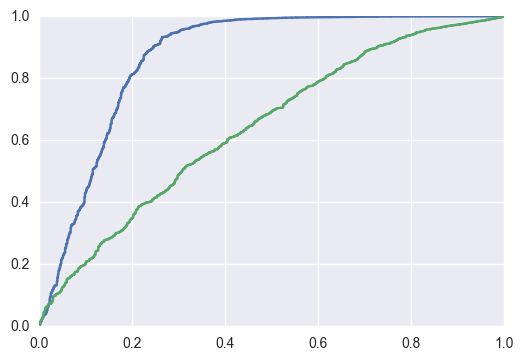

In [89]:
print metrics.roc_auc_score(y_test, pred[:, 1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred[:, 0])
plt.plot(tpr, fpr)
print metrics.roc_auc_score(dummy_y_test, dummy_pred[:, 1])
fpr, tpr, thresholds = metrics.roc_curve(dummy_y_test, dummy_pred[:, 0])
plt.plot(tpr, fpr)
plt.show()

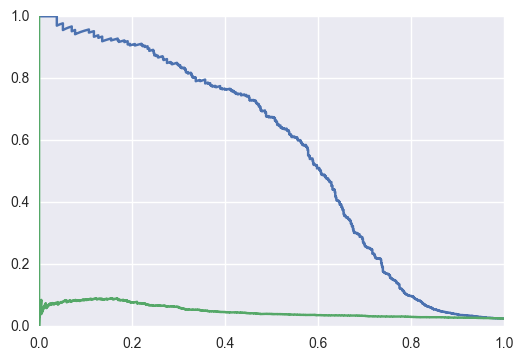

In [90]:
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, pred[:, 1])
plt.plot(tpr, fpr)
fpr, tpr, thresholds = metrics.precision_recall_curve(dummy_y_test, dummy_pred[:, 1])
plt.plot(tpr, fpr)
plt.show()